In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib, datetime

In [ ]:
#@title Record Each Cell's Execution Time
!pip install ipython-autotime

%load_ext autotime

time: 132 µs (started: 2022-02-16 08:28:41 +00:00)


In [ ]:
!wget https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip

--2022-02-16 08:28:41--  https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0htmeoie69q650p/miml_dataset.zip [following]
--2022-02-16 08:28:42--  https://www.dropbox.com/s/raw/0htmeoie69q650p/miml_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc34bf6f9fe9a60d800f09a3b676.dl.dropboxusercontent.com/cd/0/inline/Bfwzc-JUSvXaUBIftZiqQXknI8ws3XumNqTYyWNyyRVu31SlOvdJj300yQPCAe_hRnhQvMLjxXDnvmaRpp60ut8zzn4NlPdw6hTXx5uLxGhoOQcjG2eQaVFb6GSyN5e6KmqcWr6xg93pewWy6UShlmIw/file# [following]
--2022-02-16 08:28:42--  https://uc34bf6f9fe9a60d800f09a3b676.dl.dropboxusercontent.com/cd/0/inline/Bfwzc-JUSvXaUBIftZiqQXknI8ws3XumNqTYyWNyyRVu31SlOvdJj300yQPCAe_hRnhQvMLjxXD

In [ ]:
!unzip -o -q miml_dataset.zip 

time: 551 ms (started: 2022-02-16 08:28:46 +00:00)


In [ ]:
df=pd.read_csv("./miml_dataset/miml_labels_1.csv")
df.head()

,Filenames,desert,mountains,sea,sunset,trees
0,1.jpg,1,0,0,0,0
1,2.jpg,1,0,0,0,0
2,3.jpg,1,0,0,0,0
3,4.jpg,1,1,0,0,0
4,5.jpg,1,0,0,0,0


time: 34.4 ms (started: 2022-02-16 08:28:46 +00:00)


In [ ]:
df.count()

Filenames    2000
desert       2000
mountains    2000
sea          2000
sunset       2000
trees        2000
dtype: int64

time: 12.6 ms (started: 2022-02-16 08:28:46 +00:00)


In [ ]:
len(df["Filenames"])

2000

time: 7.73 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
LABELS=[]
for col in df.columns[1:]:
  LABELS.append(str(col))
print(LABELS)
print(type(LABELS[0]))

['desert', 'mountains', 'sea', 'sunset', 'trees']
<class 'str'>
time: 6.05 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
#LABELS=["desert", "mountains", "sea", "sunset", "trees"]
data_dir = pathlib.Path("miml_dataset")
filenames = list(data_dir.glob('images/*.jpg'))
fnames=[]
for fname in filenames:
  fnames.append(str(fname))
print(type(LABELS[0]))

<class 'str'>
time: 20.3 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
fnames[:5]

['miml_dataset/images/634.jpg',
 'miml_dataset/images/48.jpg',
 'miml_dataset/images/1481.jpg',
 'miml_dataset/images/458.jpg',
 'miml_dataset/images/1865.jpg']

time: 5.42 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
ds_size= len(fnames)
print("Number of images in folders: ", ds_size)
number_of_selected_samples=2000
filelist_ds = tf.data.Dataset.from_tensor_slices(fnames[:number_of_selected_samples])

ds_size= filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

Number of images in folders:  2000
Number of selected samples for dataset:  2000
time: 131 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  file_name= parts[-1]
  labels= df[df["Filenames"]==file_name][LABELS].to_numpy().squeeze()
  return tf.convert_to_tensor(labels)

time: 4.27 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
# resize and scale the images to save time in training
IMG_WIDTH, IMG_HEIGHT = 64 , 64
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  #resize 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

time: 8.86 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
# Combine the images with labels
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  img = tf.io.read_file(file_path) 
  img = decode_img(img)
  return img, label

time: 4.02 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
train_ratio = 0.80
ds_train=filelist_ds.take(ds_size*train_ratio)
ds_test=filelist_ds.skip(ds_size*train_ratio)
print(type(ds_train))

<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
time: 6.52 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
BATCH_SIZE=64

time: 658 µs (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
# Pre-process all the images
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels, inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

time: 72 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

time: 31.3 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
type(ds_test)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

time: 8.38 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
# Convert multi-hot labels to string labels
def convert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels)==0:
    labels.append("NONE")
  return labels

time: 2.78 ms (started: 2022-02-16 08:28:47 +00:00)


In [ ]:
dataset = ds_test
print(type(ds_test))
dss = dataset.take(2)
print(type(dss))
for a,b in dataset.take(3):
  print(type(a), type(b))
  #print(str(b.numpy()))
  # print(str(a.shape))
  # print(str(b.numpy()))

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
time: 2.78 s (started: 2022-02-16 08:28:49 +00:00)


9 samples from the dataset


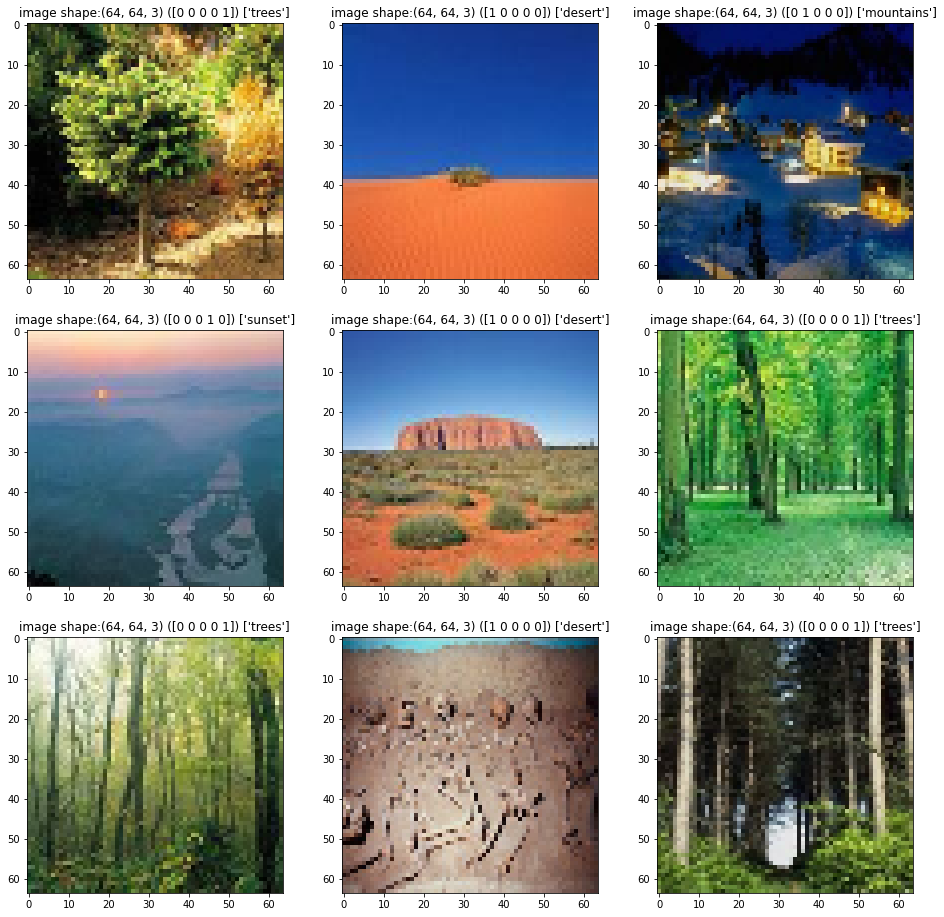

time: 12 s (started: 2022-02-16 08:28:51 +00:00)


In [ ]:
def show_samples(dataset):
  fig=plt.figure(figsize=(16, 16))
  columns = 3
  rows = 3
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +") "+ 
              str(convert_onehot_string_labels(LABELS,b.numpy())))
    i=i+1
  plt.show()
show_samples(ds_test)

In [ ]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())


Number of batches in train:  25
Number of batches in test:  7
time: 12.7 ms (started: 2022-02-16 08:29:28 +00:00)


In [ ]:
# Create a Keras CNN model by using Transfer learning
# Transfer Learning by importing VGG16
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step
time: 1.17 s (started: 2022-02-16 08:30:37 +00:00)


In [ ]:
# Create the classification model
number_of_classes = 5

time: 960 µs (started: 2022-02-16 08:30:49 +00:00)


In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

time: 83.7 ms (started: 2022-02-16 08:31:59 +00:00)


* The last layer has ***number_of_classes*** units. So the output (***y_pred***)  will be **a vector with number_of_classes dimension**.


* For the last layer, the activation function can be:
  * None 
  * sigmoid 
  * softmax
* When there is **no activation** function is used in the model's last layer, we need to set `from_logits=True` **in cross-entropy loss functions** . Thus, **cross-entropy loss functions** will apply a **sigmoid** transformation on **predicted label values** by itself:


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])

time: 21.9 ms (started: 2022-02-16 08:35:48 +00:00)


**IMPORTANT:** We need to use **keras.metrics.BinaryAccuracy()** for **measuring** the **accuracy** since it calculates how often predictions matches **binary labels**. 

As we are dealing with **multi-label** classification and true lables are encoded **multi-hot**, we need to compare ***pairwise (binary!)***:  each element of prediction with the corresponding element of true lables. 




In [ ]:
model.fit(ds_train_batched, validation_data=ds_test_batched, epochs=50)

Epoch 1/50
25/25 [==============================] - 1285s 52s/step - loss: 0.6291 - binary_accuracy: 0.6630 - val_loss: 0.5556 - val_binary_accuracy: 0.7515
Epoch 2/50
25/25 [==============================] - 79s 3s/step - loss: 0.5348 - binary_accuracy: 0.7531 - val_loss: 0.5187 - val_binary_accuracy: 0.7530
Epoch 3/50
25/25 [==============================] - 79s 3s/step - loss: 0.4990 - binary_accuracy: 0.7608 - val_loss: 0.4878 - val_binary_accuracy: 0.7655
Epoch 4/50
25/25 [==============================] - 79s 3s/step - loss: 0.4715 - binary_accuracy: 0.7750 - val_loss: 0.4644 - val_binary_accuracy: 0.7745
Epoch 5/50
25/25 [==============================] - 79s 3s/step - loss: 0.4500 - binary_accuracy: 0.7890 - val_loss: 0.4467 - val_binary_accuracy: 0.7870
Epoch 6/50
25/25 [==============================] - 79s 3s/step - loss: 0.4330 - binary_accuracy: 0.8004 - val_loss: 0.4327 - val_binary_accuracy: 0.7970
Epoch 7/50
25/25 [==============================] - 79s 3s/step - loss: 0

time: 1h 28min 22s (started: 2022-02-16 08:37:21 +00:00)


In [ ]:
ds= ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

7/7 [==============================] - 16s 2s/step - loss: 0.3225 - binary_accuracy: 0.8580
Test Accuracy:  0.8580000400543213
time: 16.1 s (started: 2022-02-16 10:37:51 +00:00)


In [ ]:
#10 sample predictions
ds=ds_test
predictions= model.predict(ds.batch(batch_size=10).take(1))
print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " ,pred, str(convert_onehot_string_labels(LABELS, pred)),  
        "Actual Label: ("+str(convert_onehot_string_labels(LABELS,b.numpy())) +")")
  y.append(b.numpy())

A sample output from the last layer (model)  [0.8064126  0.03531083 0.20278561 0.16678852 0.02113965]
10 Sample predictions:
predicted:  [1. 0. 0. 0. 0.] ['desert'] Actual Label: (['trees'])
predicted:  [0. 0. 0. 0. 1.] ['trees'] Actual Label: (['desert'])
predicted:  [0. 0. 0. 0. 0.] ['NONE'] Actual Label: (['sunset'])
predicted:  [0. 0. 0. 0. 0.] ['NONE'] Actual Label: (['mountains'])
predicted:  [0. 0. 0. 0. 0.] ['NONE'] Actual Label: (['trees'])
predicted:  [0. 0. 0. 0. 1.] ['trees'] Actual Label: (['desert'])
predicted:  [0. 0. 0. 0. 1.] ['trees'] Actual Label: (['trees'])
predicted:  [1. 0. 0. 0. 0.] ['desert'] Actual Label: (['desert'])
predicted:  [0. 0. 0. 0. 1.] ['trees'] Actual Label: (['sea'])
predicted:  [0. 0. 1. 1. 0.] ['sea', 'sunset'] Actual Label: (['trees'])
time: 15.2 s (started: 2022-02-16 10:39:16 +00:00)


## Obtained Results*:





| Activation | Loss | Accuracy |
| :- | -: | :-: |
| softmax | BinaryCrossentropy() |0.8675
| **sigmoid** | **BinaryCrossentropy()** |**0.8810**
| None | BinaryCrossentropy(from_logits=True) | 0.8705
| softmax  |  CategoricalCrossentropy() |0.8665
| sigmoid |  CategoricalCrossentropy() | 0.7460
| None |  CategoricalCrossentropy(from_logits=True) | 0.2540
| softmax | SparseCategoricalCrossentropy() |InvalidArgumentError:  labels must be 1-D, but got shape [64,5]
| sigmoid | SparseCategoricalCrossentropy() | InvalidArgumentError:  labels must be 1-D, but got shape [64,5]
| None | SparseCategoricalCrossentropy(from_logits=True) |InvalidArgumentError:  labels must be 1-D, but got shape [64,5]




   *When you run this notebook, most probably you would not get the exact numbers rather you would observe very similar values due to the stochastic nature of ANNs.* 

According to the above experiment results, if the task is **multi-label classification**, we need to set-up:

* true (actual) labels encoding = **multi-hot vector**

* activation = **sigmoid**

* loss = **BinaryCrossentropy()**

* accuracy metric= **BinaryAccuracy()**







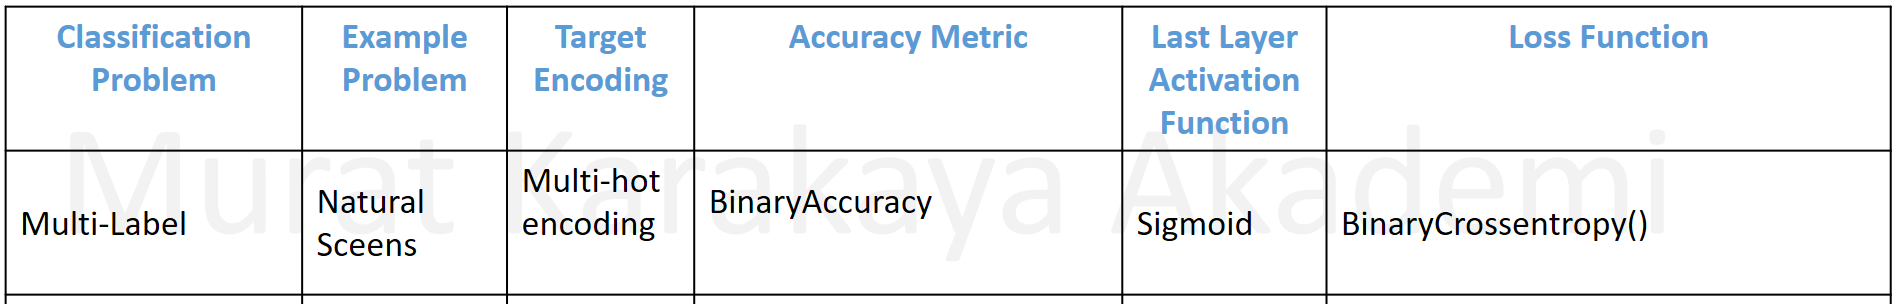